# Conditional GAN tutorial

 This tutorial covers how to build a conditional GAN for the MNIST dataset, where you can specify the label of the output image by inputting the labels.

### Introduction:
Generative Adversarial Network (GAN) is a machine learning method that generates “real looking” data from noise. It uses 2 neural networks, one generator and one discriminator. The generator’s job is to generate the data, and the discriminator’s job is to tell whether a sample is true or fake (created by the generator). 

The networks are trained alternatively for each batch, first the discriminator and then the generator, so that they both improve together against each other (thus “Adversarial”). When the generator is good enough that the discriminator can’t tell a real from a fake image well, you have a good enough generator.

A good example of a GAN application is generating handwritten digits, like those in the well known MNIST dataset. A GAN can be trained to generate images just like those in the dataset.


### The problem: What is the label of the output?
If we can generate images of digits, the next question is what digit is generated by the GAN? Traditional GANs generate real looking data, but they don’t specify the class of the data they are generating. 

On the digit example, it’s like the GAN generates the digit, but you can’t know which digit it was.

Conditional GANs come to solve this problem with a simple idea, to include label information in the input of both the generator and discriminator, so that the networks can leverage this information when learning and add more control to the generated images.




#### Let's start coding a Conditional GAN for the MNIST dataset

In [1]:
# importing libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### Loading the data 
We'll start by loading our data.
The MNIST dataset is made of 60,000 development samples and 10,000 testing samples. 
In this tutorial we'll use only the development dataset. As a good practice, 
we'll also shuffle it after loading

In [2]:
# load MNIST dataset
(X_dev,y_dev),(_,_) = tf.keras.datasets.mnist.load_data()

# shuffle data
indexes = np.arange(X_dev.shape[0],dtype=int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
y_dev = y_dev[indexes]

### Setting Up some Parameters and Processing the Data
We'll set up a few parameters, such as batch size and latent dimension (the size of the noise vector). We'll also declare some variables to hold 
some information on the dataset, such as size, number of channels and classes.

We'll also normalize the images to the range of \[0,1] and convert the labels to one hot encoding.

In [3]:
# define some parameters for the model
batch_size = 128
num_channels = 1
num_classes = 10 
image_size = 28
latent_dim = 128 # noise vector size

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_images = X_dev.astype("float32") / 255.0
all_images = np.reshape(all_images, (-1, 28, 28, 1))
all_labels = tf.keras.utils.to_categorical(y_dev, 10)


# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)


# just checking shape of training data
print(f"Shape of training images: {all_images.shape}")
print(f"Shape of training labels: {all_labels.shape}")


generator_in_channels = latent_dim # Number of input channels to the generator (excluding label)
discriminator_in_channels = num_channels # Number of input channels to the discriminator (excluding label)

Shape of training images: (60000, 28, 28, 1)
Shape of training labels: (60000, 10)


### Generator Model:
The generator needs to have 2 distinct inputs, one for the noise and one for the labels. These must then be joined and the output must be in the same format as the images, 28 by 28 matrices. To do so, we will use Transpose 2D convolutions with 2x2 strides to upscale the dimensions and leaky Relu activations to better handle the sparsity of the dataset. The generator layer diagram is as follows:

![alt text](gen.png "Title")


The generator model is defined as a function:


In [5]:
# Defining Generator model
def generator():

    # Label input, so that generator can generate 
    # image of choosen class
    label_input = tf.keras.layers.Input((num_classes))
    # changing number of nodes with a dense layer 
    label_dense = tf.keras.layers.Dense(7*7*1, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(label_input)
    # Reshaping into 2D So that we can input this into a convolutional layer and concatenate with the noise
    label_reshape = tf.keras.layers.Reshape((7,7,1))(label_dense)
    
    # Noise input
    random_input = tf.keras.layers.Input(generator_in_channels)
    # dense layer to adjust size
    x1 = tf.keras.layers.Dense(7*7*generator_in_channels, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(random_input)
    # Reshaping into 2D So that we can input this into a convolutional layer and concatenate
    x2 = tf.keras.layers.Reshape((7,7,generator_in_channels))(x1)

    #Combining both Label and Noise inputs using concatenation
    x3 = tf.keras.layers.Concatenate()([x2,label_reshape])

    # Upsample to 14x14 with transpose convolution
    x4 = tf.keras.layers.Conv2DTranspose(256,(4,4),strides=(2,2),activation=tf.keras.layers.LeakyReLU(alpha=0.2),padding="same")(x3)
    # Upsample to 28x28 with transpose convolution
    x5 = tf.keras.layers.Conv2DTranspose(128,(4,4),strides=(2,2),activation=tf.keras.layers.LeakyReLU(alpha=0.2),padding="same")(x4)
    # Collapsing 3rd dimension to 1, so that it's the same shape as image
    x6 = tf.keras.layers.Conv2D(1,(7,7),padding="same",activation="sigmoid")(x5)

    model = tf.keras.models.Model(inputs=[random_input,label_input], outputs=x6)
    return model

# declare generator and print summary for inspection
generator_model = generator()
print(generator_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 6272)         809088      ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 49)           539         ['input_1[0][0]']                
                                                                                              

### Discriminator Model:
The discriminator also needs 2 inputs, one for the image and one for the label. Just like in the generator, those inputs will be concatenated
and follow on to become the output of the network.

The discriminator uses similar layers to the generator, but instead of a Transpose Convolutional layer, it uses a regular convolutional layer with
2x2 strides to downsample the dimensions. The discriminator layer diagram is as follows:


![alt text](dis.png "Title")


The discriminator code is defined as a function:


In [6]:
def discriminator():
    # Label input, so that discriminator knows the label
    # of the image it tries to discriminate
    label_input = tf.keras.layers.Input((num_classes))
    # changing number of nodes with a dense layer 
    label_dense = tf.keras.layers.Dense(14*14, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(label_input)
    # Reshaping into 2D So that we can input this into a convolutional layer and concatenate to image
    label_reshape = tf.keras.layers.Reshape((14,14,1))(label_dense)

    # Image input
    x1 = tf.keras.layers.Input((image_size,image_size,1))
    # stride of 2x2 means downsampling to 14x14
    x2 = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2),activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding="same")(x1) 

    # Combining Both label and Image inputs using Concatenation, so that label is added in 3rd dimension of shape
    x3 = tf.keras.layers.Concatenate()([x2,label_reshape])
    # stride of 2x2 downsampling to 7x7
    x4 = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2),activation=tf.keras.layers.LeakyReLU(alpha=0.2), padding="same")(x3)
    # global max collapses first and second dimensions to 1
    globalmaxpool = tf.keras.layers.GlobalMaxPooling2D()(x4)
    # last layer with 1 node for deciding if image is real or not
    final_layer = tf.keras.layers.Dense(1,activation="sigmoid")(globalmaxpool)

    model = tf.keras.models.Model(inputs=[x1,label_input], outputs=final_layer)
    return model

# declare discriminator and print summary for inspection
discriminator_model = discriminator()
print(discriminator_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 196)          2156        ['input_3[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   640         ['input_4[0][0]']                
                                                                                            

### Defining the GAN and Training Procedure
The GAN is formed by joining the generator and the discriminator, but the training must be performed differently than in regular neural networks.
For each batch, the discriminator must be trained using real and generated data, then the generator must be trained by forward passing the whole
GAN with the input noise and assigning the y_data for the discriminator as 1, meaning that we wish for the discriminator to ouput that all samples
were true while they were all false. One important note is that the discriminator does not train its weights during the generator training part.

To perform this customized training procedure we used the subclassing API to create a ConditionalGAN class, and we altered the steps of the ".fit()" method.


In [7]:
# Creating a conditional GAN class by subclassing the Keras model class
# This is done to use the .fit function to perform a custom training procedure
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    # set optimizers for each part of model
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    #train_step function is called whenever you use model.fit()
    def train_step(self, data):
        # Unpack the data
        real_images, one_hot_labels = data

        # Sample random points in the latent space 
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode the noise (guided by labels) to fake images.
        fake_images = self.generator([random_latent_vectors,one_hot_labels])

        # Ccombine the real images with the fake images
        # do the same for the labels (but these just repeat)
        all_images = tf.concat([fake_images,real_images],axis=0)
        all_labels = tf.concat([one_hot_labels,one_hot_labels],axis=0)

        # Assemble labels discriminating real from fake images.
        # This is the labels for the discriminator, regarding if the images
        # are fake or no
        disc_labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            #Forward Pass
            predictions = self.discriminator([all_images,all_labels])
            d_loss = self.loss_fn(disc_labels, predictions)
        # Calculate gradients with respect to every trainable variable
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size*2, self.latent_dim))

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size*2, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            #Forward Pass
            fake_images = self.generator([random_latent_vectors,all_labels])
            predictions = self.discriminator([fake_images,all_labels])
            g_loss = self.loss_fn(misleading_labels, predictions)
        #Calculate gradients with respect to every trainable variable    
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

### Creating GAN and Compiling Model
We'll now create the GAN using the declared generator and discriminator.

Also, we'll compile the GAN with the RMSprop optimizer and slightly different values for the optimizer and discriminator.

In [8]:
#Intializing the GAN model
cond_gan = ConditionalGAN(
    discriminator=discriminator_model, generator=generator_model, latent_dim=latent_dim
)

#Compiling the GAN model
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.RMSprop(lr = 0.0008, clipvalue = 1.0, decay = 6e-8),
    g_optimizer=tf.keras.optimizers.RMSprop(lr = 0.0004, clipvalue = 1.0, decay = 3e-8),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

/home/rodrigo/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### Training the Model

Finally, let's train the model!

In [9]:
# Training the model
cond_gan.fit(dataset, epochs=20)

Epoch 1/20


/home/rodrigo/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


469/469 [==============================] - 24s 45ms/step - g_loss: 1.0404 - d_loss: 0.5189
Epoch 2/20
469/469 [==============================] - 21s 45ms/step - g_loss: 1.1340 - d_loss: 0.4976
Epoch 3/20
469/469 [==============================] - 21s 45ms/step - g_loss: 1.1046 - d_loss: 0.5270
Epoch 4/20
469/469 [==============================] - 21s 45ms/step - g_loss: 0.9998 - d_loss: 0.5659
Epoch 5/20
469/469 [==============================] - 21s 45ms/step - g_loss: 0.9607 - d_loss: 0.5808
Epoch 6/20
469/469 [==============================] - 21s 45ms/step - g_loss: 0.9464 - d_loss: 0.5957
Epoch 7/20
469/469 [==============================] - 21s 46ms/step - g_loss: 0.9344 - d_loss: 0.6069
Epoch 8/20
469/469 [==============================] - 21s 46ms/step - g_loss: 0.9183 - d_loss: 0.6089
Epoch 9/20
469/469 [==============================] - 21s 46ms/step - g_loss: 0.9225 - d_loss: 0.6088
Epoch 10/20
469/469 [==============================] - 22s 46ms/step - g_loss: 0.9234 - d_los

### Visualizing the Results

Now that we have a trained model, let's use it to generate some fake data. We'll get the generator of the trained GAN and input noise and labels to it, and show the resulting images together with the labels. 

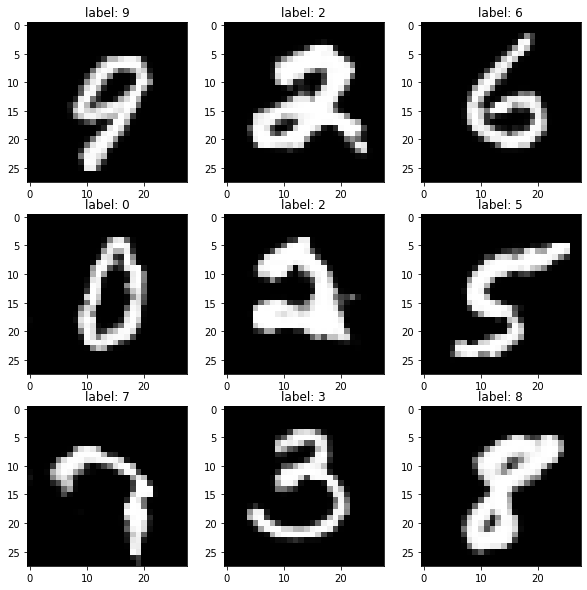

In [6]:
# Verifying if model is working properly

# get generator model only
trained_gen = cond_gan.generator

# alternative to not train (load provided trained model)
#trained_gen = tf.keras.models.load_model("trained_gen.h5")


# create random noise for input
noise = tf.random.normal(shape=(1, latent_dim*9))
noise = tf.reshape(noise, (9, latent_dim))

# Create random label list
random_labels_list = list(np.random.randint(0,10,size=9))

# convert to one hot encoding
labels = tf.keras.utils.to_categorical(random_labels_list, num_classes)

# Use the generator to generate fake images
fake = trained_gen.predict([noise,labels])

# plot the images in a 3 by 3 plot, with the labels in the title
fig,ax = plt.subplots(3,3)

fig.set_figheight(10)
fig.set_figwidth(10)

for i in range(0,3):
    for j in range(0,3):
        ax[i,j].imshow(fake[i*3+j],cmap='gray')
        ax[i,j].set_title(f"label: {random_labels_list[i*3+j]}")

In [34]:
#saving the generator for later use
tf.keras.models.save_model(trained_gen,"trained_gen.h5")

## The End

Now we are able to generate the handwritten digit of our choice by controlling the labels inputted to the generator. 

You can now try to use this CGAN on different datasets or tweak the model!